<a href="https://colab.research.google.com/github/rajy4683/S15Test/blob/master/S15ResUnet6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue May 19 11:41:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    68W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import sys

Mounted at /content/drive


In [0]:
sys.path.append('/content/drive/My Drive/EVA4/RekogNizer')
sys.path.append('/content/drive/My Drive/EVA4')
sys.path.append('/content/drive/My Drive/EVA4/DenseDepth')

In [0]:
!folder_list=("classroom" "college_outdoors" "corridors" "dining_room" "malls" "lobby" "meeting_rooms" "people_cropresize"); for folder_name in ${folder_list[@]}; do mkdir -p /content/S15EVA4/$folder_name /content/S15EVA4/$folder_name/aug_images; cp -Rf /content/drive/My\ Drive/EVA4/tsai/S15EVA4/$folder_name/*png /content/S15EVA4/$folder_name; done

### Dependencies


In [4]:
!pip install -r /content/drive/My\ Drive/EVA4/RekogNizer/requirements.txt

In [5]:
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-jobx3pf8
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-jobx3pf8
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65055 sha256=65b22fdd3e8f293764dad882826a873839774f4cdaed29e18f050b0c1b11a1bd
  Stored in directory: /tmp/pip-ephem-wheel-cache-ubudxwhw/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.4.5
    Uninstalling albumentations-0.4.5:
      Successfully uninstalled albumentations-0.4.5


In [0]:
import os

import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.color import label2rgb

import albumentations as A
import random
from google.colab.patches import cv2_imshow
from PIL import Image
import glob
import pandas as pd

import torch
from zipfile import ZipFile
import re
import h5py
import time



In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
from RekogNizer import hyperparams

from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, Resize, Cutout, MotionBlur
from albumentations import (
    HorizontalFlip, Compose, RandomCrop, Cutout,Normalize, HorizontalFlip, RandomBrightnessContrast,
    Resize,RandomSizedCrop, MotionBlur,MultiplicativeNoise,InvertImg, IAAFliplr,
	IAAPerspective,
)
from albumentations.pytorch import ToTensor
import random

from torchvision.datasets.vision import VisionDataset
from torchvision.datasets.utils import check_integrity, download_and_extract_archive
import os
import sys
import numpy as np
from torchvision import datasets
#from RekogNizer import imgnetloader
from RekogNizer import basemodelclass
from RekogNizer import mmdtraintest
from RekogNizer import mmddataloader
from RekogNizer import hyperparams
from RekogNizer import fileutils
from RekogNizer import mmdlosses
from RekogNizer import mmdmodels


from torch.utils.data import Dataset
import shutil
from tqdm import tqdm


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, OneCycleLR, MultiStepLR, CyclicLR, ReduceLROnPlateau


import kornia

import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import wandb

  pip install torch-lr-finder -v --global-option="amp"
  pip install torch-lr-finder -v --global-option="amp"


In [8]:
!wandb login a6f947d2d2f69e7a8c8ca0f69811fd554f27d204
#tqdm._instances.clear()

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [0]:
!rm -rf /content/train && mkdir -p /content/train
!rm -rf /content/test && mkdir -p /content/test

In [0]:
tqdm._instances.clear()

In [30]:
%%time
csv_file ='/content/drive/My Drive/EVA4/tsai/S15EVA4/FinalDataSet/DepthMapDataSetTrain.csv'
root_dir = '/content/drive/My Drive/EVA4/tsai/S15EVA4/'
batch_start = 120000
batch_end = batch_start+50000
dest_dir="/content/train"

mmddataloader.extract_data_files_mt(csv_file, root_dir, batch_start,batch_end, dest_dir=dest_dir)

Extracting image and mask files Total:9
Zip Name:depth_mask_gt_1k2k.zip Total Files:8330
Zip Name:image_mask_gt6k8k.zip Total Files:16262
Zip Name:image_mask_gt1k2k.zip Total Files:16660
Zip Name:image_mask_gt8k12k.zip Total Files:33946
Zip Name:image_mask_gt2k6k.zip Total Files:33134
Zip Name:depth_mask_gt_2k6k.zip Total Files:16567
Zip Name:depth_mask_gt_6k8k.zip Total Files:8131
Zip Name:depth_mask_gt_8k12k.zip Total Files:16973
Extracting bg files
Total file count:150113 
CPU times: user 9.85 s, sys: 1.26 s, total: 11.1 s
Wall time: 17min 24s


In [0]:
len(glob.glob("/content/train/*jpg"))

150113

In [10]:
%%time
csv_file ='/content/drive/My Drive/EVA4/tsai/S15EVA4/FinalDataSet/DepthMapDataSetTrain.csv'

size_hw = (56,56)
dest_dir="/content/train"
batch_start = 120000
batch_end = batch_start+10000
train_batch_size = 128
depth_dataset = mmddataloader.DepthMaskDataSet(csv_file, dest_dir, batch_start,batch_end, read_zip=False,
                                 transform_base=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.56632738, 0.51567622, 0.45670792], [0.1076622, 0.10650349, 0.12808967] ),
                                 transform_bg=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.57469445, 0.52241555, 0.45992244], [0.11322354, 0.11195428, 0.13441683]),
                                 transform_mask = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 transform_depth = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 #transform_mask=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.0579508], [0.001662]),
                                 #transform_depth=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.3679109], [0.03551773]),
                                 )
from torch.utils.data import DataLoader
kwargs= { 'num_workers':8,'pin_memory': True}
train_loader = DataLoader(depth_dataset, batch_size=train_batch_size, shuffle=False, **kwargs)


CPU times: user 1.11 s, sys: 104 ms, total: 1.22 s
Wall time: 1.32 s


In [0]:
test_csv_file ='/content/drive/My Drive/EVA4/tsai/S15EVA4/FinalDataSet/DepthMapDataSetTest.csv'
root_dir = '/content/drive/My Drive/EVA4/tsai/S15EVA4/'
test_batch_start = 0
test_batch_end = test_batch_start + 512
test_batch_size=16
test_dest_dir = "/content/test"

mmddataloader.extract_data_files(test_csv_file, root_dir, test_batch_start,test_batch_end, dest_dir=test_dest_dir)

In [0]:
size_hw = (56,56)
test_dest_dir = "/content/test"
test_dataset = mmddataloader.DepthMaskDataSet(test_csv_file, test_dest_dir, test_batch_start,test_batch_end,read_zip=False,
                                 transform_base=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.56632738, 0.51567622, 0.45670792], [0.1076622, 0.10650349, 0.12808967] ),
                                 transform_bg=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.57469445, 0.52241555, 0.45992244], [0.11322354, 0.11195428, 0.13441683]),
                                 transform_mask = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 transform_depth = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 #transform_mask=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.0579508], [0.001662]),
                                 #transform_depth=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.3679109], [0.03551773]),
                                 )
from torch.utils.data import DataLoader
kwargs= { 'num_workers':4,'pin_memory': True}
test_loader = DataLoader(test_dataset, batch_size=26, shuffle=False, **kwargs)

In [0]:
glob.glob(test_dest_dir+"/*jpg")

In [0]:
#csv_file = '/content/drive/My Drive/EVA4/tsai/S15EVA4/DepthMapDataSetSample.csv'
batch_start = 70000
batch_end = batch_start+30000
train_batch_size = 64

test_batch_start = 0
test_batch_end = test_batch_start + 512
test_batch_size=16

csv_file ='/content/drive/My Drive/EVA4/tsai/S15EVA4/FinalDataSet/DepthMapDataSetTrain.csv'
test_csv_file = '/content/drive/My Drive/EVA4/tsai/S15EVA4/FinalDataSet/DepthMapDataSetTest.csv'

root_dir = '/content/drive/My Drive/EVA4/tsai/S15EVA4/'
size_hw = (64,64)
#size_hw = (224,224)
depth_dataset = mmddataloader.DepthMaskDataSet(csv_file, root_dir, batch_start,batch_end, read_zip=True,
                                 transform_base=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.56632738, 0.51567622, 0.45670792], [0.1076622, 0.10650349, 0.12808967] ),
                                 transform_bg=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.57469445, 0.52241555, 0.45992244], [0.11322354, 0.11195428, 0.13441683]),
                                 transform_mask = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 transform_depth = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 #transform_mask=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.0579508], [0.001662]),
                                 #transform_depth=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.3679109], [0.03551773]),
                                 )
from torch.utils.data import DataLoader
kwargs= { 'num_workers':1,'pin_memory': True}
train_loader = DataLoader(depth_dataset, batch_size=train_batch_size, shuffle=False, **kwargs)

test_dataset = mmddataloader.DepthMaskDataSet(test_csv_file, root_dir, test_batch_start,test_batch_end,read_zip=True,
                                 transform_base=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.56632738, 0.51567622, 0.45670792], [0.1076622, 0.10650349, 0.12808967] ),
                                 transform_bg=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.57469445, 0.52241555, 0.45992244], [0.11322354, 0.11195428, 0.13441683]),
                                 transform_mask = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 transform_depth = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 #transform_mask=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.0579508], [0.001662]),
                                 #transform_depth=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.3679109], [0.03551773]),
                                 )
from torch.utils.data import DataLoader
kwargs= { 'num_workers':1,'pin_memory': True}
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, **kwargs)


Learning rate search finished. See the graph with {finder_name}.plot()
0.07943282347242817 1.0 1.4046657085418701
{'lr': [0.010471285480508996, 0.01096478196143185, 0.011481536214968828, 0.01202264434617413, 0.012589254117941673, 0.013182567385564071, 0.013803842646028849, 0.014454397707459274, 0.015135612484362083, 0.015848931924611138, 0.016595869074375606, 0.017378008287493755, 0.018197008586099836, 0.019054607179632473, 0.019952623149688795, 0.020892961308540396, 0.021877616239495527, 0.02290867652767773, 0.023988329190194904, 0.0251188643150958, 0.026302679918953818, 0.027542287033381664, 0.02884031503126606, 0.03019951720402016, 0.0316227766016838, 0.03311311214825911, 0.034673685045253165, 0.03630780547701014, 0.03801893963205612, 0.03981071705534972, 0.04168693834703354, 0.043651583224016605, 0.045708818961487506, 0.04786300923226384, 0.05011872336272722, 0.05248074602497726, 0.05495408738576246, 0.057543993733715694, 0.06025595860743578, 0.06309573444801933, 0.066069344800759

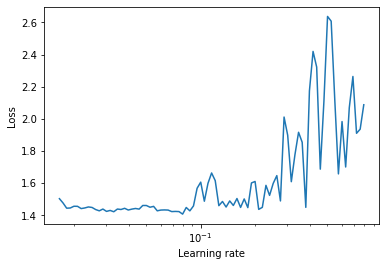

In [68]:
### LR finder ###
from RekogNizer import mmdtraintest
#criterion={"mask":[mmdlosses.dice_loss, mmdlosses.LocalBCELoss], "depth":[mmdlosses.LocalL1Loss, mmdlosses.LocalSSIMLoss]}
criterion={"mask":[mmdlosses.dice_loss, mmdlosses.LocalL1Loss], 
           "depth":[mmdlosses.LocalRMSELoss, mmdlosses.LocalSSIMLoss]}


#model_new = mmdmodels.UNet(n_channels=6, n_classes=2)
model_new = mmdmodels.ResNetUNet(2)
optimizer=optim.SGD(model_new.parameters(), lr=0.001,momentum=0.9,  weight_decay=0)

lrfinder = mmdtraintest.find_lr_type1(model_new, optimizer, criterion, train_loader, testloader=None, seed=1, start_lr=0.01, end_lr=1, step_mode="exp",num_iter=100)
min_lr = lrfinder.history['lr'][np.argmin(lrfinder.history['loss'])]
max_lr = np.max(lrfinder.history['lr'])

print(min_lr, max_lr, np.min(lrfinder.history['loss']))
print(lrfinder.history)
lrfinder.plot()
lrfinder.reset()


In [0]:
np.min(lrfinder.history['loss'])

0.5309022665023804

In [0]:
del model_new
torch.cuda.empty_cache()

In [0]:
from torchvision import models
base_model = models.resnet18(pretrained=False)

In [0]:
base_model_children = list(base_model.children())

In [39]:
base_model_children[:3]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True)]

In [38]:
base_model_children[3:5]

[MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
 )]

In [0]:
summary(base_model.to(device),input_size=(3, 224,224))

In [0]:
# #model.eval()
device = torch.device("cuda" if not hyperparams.hyperparameter_defaults['no_cuda'] else "cpu")
#model_new  =mmdmodels.UNet(n_channels=6, n_classes=2)
model_new = mmdmodels.ResNetUNet(2)
# model_new = mmdtraintest.load_model_for_infer(model_new, 
#                                   '/content/drive/My Drive/EVA4/model_saves/model-a396bcbcf1.h5',
#                                   device)

In [0]:
summary(model_new.to(device),input_size=(6, 56,56))

In [0]:
!date

Sun May 17 11:08:10 UTC 2020


### 0th Baseline: /content/drive/My Drive/EVA4/model_saves/model-978efe44ad.h5 (UNet + 

```
criterion={"mask":[mmdlosses.dice_loss, mmdlosses.LocalBCELoss],            "depth":[mmdlosses.LocalL1Loss, mmdlosses.LocalSSIMLoss]})
```
### 1st Baseline: /content/drive/My Drive/EVA4/model_saves/model-21a9faf062.h5
### 2nd Baseline : /content/drive/My Drive/EVA4/model_saves/model-71d138349a.h5 
```
 criterion={"mask":[mmdlosses.dice_loss, mmdlosses.LocalBCELoss, mmdlosses.LocalL1Loss], "depth":[mmdlosses.LocalL1Loss, mmdlosses.LocalSSIMLoss]}
 ```
 



### 3rd Baseline: /content/drive/My Drive/EVA4/model_saves/model-21a9faf062.h5
##### Observed that mask images have grayscale flipped. Time to use Pixel-Weighted Map

In [0]:
del model_new

In [14]:
######## OCP 
from RekogNizer import mmdmodels
device = torch.device("cuda" if not hyperparams.hyperparameter_defaults['no_cuda'] else "cpu")
#tqdm._instances.clear()
hyperparams.set_hyperparam({"epochs":10})

hyperparams.hyperparameter_defaults['run_name'] = fileutils.rand_run_name()
hyperparams.hyperparameter_defaults['epochs'] = 20
hyperparams.hyperparameter_defaults['lr'] = 0.07943282347242817
hyperparams.hyperparameter_defaults['ocp_max_lr'] = 0.07943282347242817

print("Initializing datasets and dataloaders")    
model_new = mmdmodels.ResNetUNet(2)

#model_new =  mmdmodels.UNet(n_channels=6, n_classes=2)
wandb_run_init = wandb.init(config=hyperparams.hyperparameter_defaults, 
                            project=hyperparams.hyperparameter_defaults['project'])
#wandb.watch_called = False
config = wandb.config
print(config)
#wandb.watch(model_new, log="none")

optimizer=optim.SGD(model_new.parameters(), lr=config.lr,momentum=config.momentum,
                        weight_decay=0)

criterion={"mask":[mmdlosses.dice_loss, mmdlosses.LocalL1Loss], 
           "depth":[mmdlosses.LocalRMSELoss, mmdlosses.LocalSSIMLoss]}

#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True, threshold=0.0001)
scheduler = OneCycleLR(optimizer, 
                        config.ocp_max_lr, 
                        epochs=config.epochs, 
                        cycle_momentum=False, 
                        steps_per_epoch=len(train_loader), 
                        base_momentum=config.momentum,
                        max_momentum=0.95, 
                        pct_start=0.2,
                        anneal_strategy=config.anneal_strategy,
                        div_factor=config.div_factor,
                        final_div_factor=config.final_div_factor
                           )

final_model_path = mmdtraintest.execute_model(model_new, 
            hyperparams.hyperparameter_defaults, 
            train_loader, test_loader, 
            device, 
            wandb=wandb,
            optimizer_in=optimizer,
            scheduler=scheduler,
            prev_saved_model=None,
            criterion=criterion,
            save_best=True,
            lars_mode=False,
            batch_step=True)

Initializing datasets and dataloaders


wandb_version: 1

_wandb:
  desc: null
  value:
    cli_version: 0.8.36
    framework: torch
    is_jupyter_run: true
    is_kaggle_kernel: false
    python_version: 3.6.9
anneal_strategy:
  desc: null
  value: linear
batch_size:
  desc: null
  value: 512
bias:
  desc: null
  value: false
cycle_momentum:
  desc: null
  value: false
div_factor:
  desc: null
  value: 128
dropout:
  desc: null
  value: 0.1
epochs:
  desc: null
  value: 20
factor:
  desc: null
  value: 0.0
final_div_factor:
  desc: null
  value: 64
lr:
  desc: null
  value: 0.07943282347242817
lr_decay_threshold:
  desc: null
  value: 0.0
lr_policy:
  desc: null
  value: ocp
momentum:
  desc: null
  value: 0.9
no_cuda:
  desc: null
  value: false
ocp_max_lr:
  desc: null
  value: 0.07943282347242817
pct_start:
  desc: null
  value: 0.208
project:
  desc: null
  value: news5
run_name:
  desc: null
  value: 26a8c7ae09
sched_lr_gamma:
  desc: null
  value: 0.5
sched_lr_step:
  desc: null
  value: 1
seed:
  desc: null
  value:

loss=1.453661 m_loss=0.968578 d_loss=0.485083 batch_id=78: 100%|██████████| 79/79 [04:35<00:00,  3.49s/it]
loss=1.4455784559249878 batch_id=19: 100%|██████████| 20/20 [00:09<00:00,  2.04it/s]



Epoch: 1 Train set: Average loss: 0.011933, Mask loss:0.004270, Depth loss:0.007663, lr:0
Epoch: 1 Test set: Average loss: 0.056435, Mask loss:0.037639, Depth loss:0.018796
Model saved as Test loss reduced from  10000.0  to  0.05643499385543734


loss=1.422853 m_loss=0.966225 d_loss=0.456628 batch_id=78: 100%|██████████| 79/79 [04:35<00:00,  3.49s/it]
loss=1.4034342765808105 batch_id=19: 100%|██████████| 20/20 [00:09<00:00,  2.05it/s]



Epoch: 2 Train set: Average loss: 0.011208, Mask loss:0.003590, Depth loss:0.007618, lr:0
Epoch: 2 Test set: Average loss: 0.055031, Mask loss:0.037549, Depth loss:0.017482
Model saved as Test loss reduced from  0.05643499385543734  to  0.05503125613660608


loss=1.396445 m_loss=0.965027 d_loss=0.431417 batch_id=78: 100%|██████████| 79/79 [04:35<00:00,  3.49s/it]
loss=1.3665142059326172 batch_id=19: 100%|██████████| 20/20 [00:09<00:00,  2.05it/s]



Epoch: 3 Train set: Average loss: 0.010975, Mask loss:0.003370, Depth loss:0.007605, lr:0
Epoch: 3 Test set: Average loss: 0.053863, Mask loss:0.037500, Depth loss:0.016363
Model saved as Test loss reduced from  0.05503125613660608  to  0.05386289053725453


loss=1.368072 m_loss=0.964137 d_loss=0.403935 batch_id=78: 100%|██████████| 79/79 [04:34<00:00,  3.48s/it]
loss=1.3324995040893555 batch_id=19: 100%|██████████| 20/20 [00:09<00:00,  2.05it/s]



Epoch: 4 Train set: Average loss: 0.010748, Mask loss:0.003151, Depth loss:0.007597, lr:0
Epoch: 4 Test set: Average loss: 0.052703, Mask loss:0.037463, Depth loss:0.015241
Model saved as Test loss reduced from  0.05386289053725453  to  0.052703426362943


loss=1.342451 m_loss=0.963350 d_loss=0.379101 batch_id=78: 100%|██████████| 79/79 [04:35<00:00,  3.49s/it]
loss=1.3066701889038086 batch_id=19: 100%|██████████| 20/20 [00:09<00:00,  2.05it/s]



Epoch: 5 Train set: Average loss: 0.010549, Mask loss:0.002959, Depth loss:0.007590, lr:0
Epoch: 5 Test set: Average loss: 0.051733, Mask loss:0.037431, Depth loss:0.014301
Model saved as Test loss reduced from  0.052703426362943  to  0.05173292657320495


loss=1.319106 m_loss=0.962677 d_loss=0.356428 batch_id=78: 100%|██████████| 79/79 [04:34<00:00,  3.48s/it]
loss=1.2877724170684814 batch_id=19: 100%|██████████| 20/20 [00:09<00:00,  2.07it/s]



Epoch: 6 Train set: Average loss: 0.010383, Mask loss:0.002799, Depth loss:0.007584, lr:0
Epoch: 6 Test set: Average loss: 0.050943, Mask loss:0.037405, Depth loss:0.013539
Model saved as Test loss reduced from  0.05173292657320495  to  0.05094345480377911


loss=1.295698 m_loss=0.962123 d_loss=0.333575 batch_id=78: 100%|██████████| 79/79 [04:35<00:00,  3.49s/it]
loss=1.2715873718261719 batch_id=19: 100%|██████████| 20/20 [00:09<00:00,  2.04it/s]



Epoch: 7 Train set: Average loss: 0.010229, Mask loss:0.002650, Depth loss:0.007579, lr:0
Epoch: 7 Test set: Average loss: 0.050205, Mask loss:0.037383, Depth loss:0.012822
Model saved as Test loss reduced from  0.05094345480377911  to  0.05020469671104386


loss=1.272482 m_loss=0.961667 d_loss=0.310815 batch_id=78: 100%|██████████| 79/79 [04:34<00:00,  3.47s/it]
loss=1.2576433420181274 batch_id=19: 100%|██████████| 20/20 [00:09<00:00,  2.10it/s]



Epoch: 8 Train set: Average loss: 0.010083, Mask loss:0.002508, Depth loss:0.007575, lr:0
Epoch: 8 Test set: Average loss: 0.049530, Mask loss:0.037364, Depth loss:0.012166
Model saved as Test loss reduced from  0.05020469671104386  to  0.04953015245656986


loss=1.251259 m_loss=0.961266 d_loss=0.289993 batch_id=78: 100%|██████████| 79/79 [04:34<00:00,  3.48s/it]
loss=1.2475324869155884 batch_id=19: 100%|██████████| 20/20 [00:09<00:00,  2.06it/s]



Epoch: 9 Train set: Average loss: 0.009956, Mask loss:0.002384, Depth loss:0.007572, lr:0
Epoch: 9 Test set: Average loss: 0.049022, Mask loss:0.037348, Depth loss:0.011675
Model saved as Test loss reduced from  0.04953015245656986  to  0.04902245357022648


loss=1.233267 m_loss=0.960909 d_loss=0.272358 batch_id=78: 100%|██████████| 79/79 [04:35<00:00,  3.48s/it]
loss=1.2389417886734009 batch_id=19: 100%|██████████| 20/20 [00:09<00:00,  2.05it/s]



Epoch: 10 Train set: Average loss: 0.009853, Mask loss:0.002285, Depth loss:0.007568, lr:0
Epoch: 10 Test set: Average loss: 0.048631, Mask loss:0.037332, Depth loss:0.011298
Model saved as Test loss reduced from  0.04902245357022648  to  0.04863066004033674


loss=1.218508 m_loss=0.960572 d_loss=0.257936 batch_id=78: 100%|██████████| 79/79 [04:35<00:00,  3.49s/it]
loss=1.2318148612976074 batch_id=19: 100%|██████████| 20/20 [00:09<00:00,  2.09it/s]



Epoch: 11 Train set: Average loss: 0.009772, Mask loss:0.002206, Depth loss:0.007566, lr:0
Epoch: 11 Test set: Average loss: 0.048325, Mask loss:0.037319, Depth loss:0.011006
Model saved as Test loss reduced from  0.04863066004033674  to  0.04832494607445789


loss=1.205946 m_loss=0.960258 d_loss=0.245688 batch_id=78: 100%|██████████| 79/79 [04:34<00:00,  3.48s/it]
loss=1.2257050275802612 batch_id=19: 100%|██████████| 20/20 [00:09<00:00,  2.04it/s]



Epoch: 12 Train set: Average loss: 0.009705, Mask loss:0.002142, Depth loss:0.007563, lr:0
Epoch: 12 Test set: Average loss: 0.048077, Mask loss:0.037306, Depth loss:0.010771
Model saved as Test loss reduced from  0.04832494607445789  to  0.04807691034982544


loss=1.195212 m_loss=0.959970 d_loss=0.235242 batch_id=78: 100%|██████████| 79/79 [04:35<00:00,  3.48s/it]
loss=1.2206997871398926 batch_id=19: 100%|██████████| 20/20 [00:09<00:00,  2.05it/s]



Epoch: 13 Train set: Average loss: 0.009649, Mask loss:0.002088, Depth loss:0.007561, lr:0
Epoch: 13 Test set: Average loss: 0.047871, Mask loss:0.037295, Depth loss:0.010576
Model saved as Test loss reduced from  0.04807691034982544  to  0.047870569991321825


loss=1.185898 m_loss=0.959707 d_loss=0.226191 batch_id=78: 100%|██████████| 79/79 [04:34<00:00,  3.47s/it]
loss=1.2165501117706299 batch_id=19: 100%|██████████| 20/20 [00:09<00:00,  2.06it/s]



Epoch: 14 Train set: Average loss: 0.009601, Mask loss:0.002042, Depth loss:0.007559, lr:0
Epoch: 14 Test set: Average loss: 0.047695, Mask loss:0.037284, Depth loss:0.010411
Model saved as Test loss reduced from  0.047870569991321825  to  0.04769534720779627


loss=1.177842 m_loss=0.959471 d_loss=0.218371 batch_id=78: 100%|██████████| 79/79 [04:35<00:00,  3.48s/it]
loss=1.2129861116409302 batch_id=19: 100%|██████████| 20/20 [00:09<00:00,  2.06it/s]



Epoch: 15 Train set: Average loss: 0.009558, Mask loss:0.002001, Depth loss:0.007557, lr:0
Epoch: 15 Test set: Average loss: 0.047543, Mask loss:0.037274, Depth loss:0.010269
Model saved as Test loss reduced from  0.04769534720779627  to  0.047543048626265794


loss=1.170872 m_loss=0.959258 d_loss=0.211614 batch_id=78: 100%|██████████| 79/79 [04:34<00:00,  3.47s/it]
loss=1.209730625152588 batch_id=19: 100%|██████████| 20/20 [00:09<00:00,  2.08it/s]



Epoch: 16 Train set: Average loss: 0.009520, Mask loss:0.001965, Depth loss:0.007555, lr:0
Epoch: 16 Test set: Average loss: 0.047410, Mask loss:0.037266, Depth loss:0.010145
Model saved as Test loss reduced from  0.047543048626265794  to  0.04741045954631783


loss=1.164840 m_loss=0.959064 d_loss=0.205777 batch_id=78: 100%|██████████| 79/79 [04:34<00:00,  3.48s/it]
loss=1.2068017721176147 batch_id=19: 100%|██████████| 20/20 [00:09<00:00,  2.08it/s]



Epoch: 17 Train set: Average loss: 0.009486, Mask loss:0.001933, Depth loss:0.007553, lr:0
Epoch: 17 Test set: Average loss: 0.047292, Mask loss:0.037258, Depth loss:0.010034
Model saved as Test loss reduced from  0.04741045954631783  to  0.04729200687557168


loss=1.159582 m_loss=0.958887 d_loss=0.200694 batch_id=78: 100%|██████████| 79/79 [04:34<00:00,  3.47s/it]
loss=1.2043821811676025 batch_id=19: 100%|██████████| 20/20 [00:09<00:00,  2.06it/s]



Epoch: 18 Train set: Average loss: 0.009455, Mask loss:0.001904, Depth loss:0.007552, lr:0
Epoch: 18 Test set: Average loss: 0.047189, Mask loss:0.037250, Depth loss:0.009938
Model saved as Test loss reduced from  0.04729200687557168  to  0.04718869912926449


loss=1.154813 m_loss=0.958720 d_loss=0.196092 batch_id=78: 100%|██████████| 79/79 [04:35<00:00,  3.48s/it]
loss=1.2023911476135254 batch_id=19: 100%|██████████| 20/20 [00:09<00:00,  2.06it/s]



Epoch: 19 Train set: Average loss: 0.009427, Mask loss:0.001877, Depth loss:0.007550, lr:0
Epoch: 19 Test set: Average loss: 0.047096, Mask loss:0.037243, Depth loss:0.009853
Model saved as Test loss reduced from  0.04718869912926449  to  0.04709618505213925


loss=1.150621 m_loss=0.958568 d_loss=0.192053 batch_id=78: 100%|██████████| 79/79 [04:35<00:00,  3.48s/it]
loss=1.2005664110183716 batch_id=19: 100%|██████████| 20/20 [00:09<00:00,  2.03it/s]



Epoch: 20 Train set: Average loss: 0.009401, Mask loss:0.001852, Depth loss:0.007549, lr:0
Epoch: 20 Test set: Average loss: 0.047012, Mask loss:0.037237, Depth loss:0.009775
Model saved as Test loss reduced from  0.04709618505213925  to  0.04701192337169982
Final model save path: /content/drive/My Drive/EVA4/model_saves/model-26a8c7ae09.h5  best loss: 0.04701192337169982


In [0]:
######## OCP 
from RekogNizer import mmdmodels
device = torch.device("cuda" if not hyperparams.hyperparameter_defaults['no_cuda'] else "cpu")
tqdm._instances.clear()
hyperparams.set_hyperparam({"epochs":10})

hyperparams.hyperparameter_defaults['run_name'] = fileutils.rand_run_name()
hyperparams.hyperparameter_defaults['epochs'] = 40
hyperparams.hyperparameter_defaults['lr'] = 2.5000e-02
hyperparams.hyperparameter_defaults['ocp_max_lr'] = 2.5000e-02

print("Initializing datasets and dataloaders")    

#model_new =  mmdmodels.UNet(n_channels=6, n_classes=2)
wandb_run_init = wandb.init(config=hyperparams.hyperparameter_defaults, 
                            project=hyperparams.hyperparameter_defaults['project'])
#wandb.watch_called = False
config = wandb.config
print(config)
#wandb.watch(model_new, log="none")

optimizer=optim.SGD(model_new.parameters(), lr=config.lr,momentum=config.momentum,
                        weight_decay=0)

criterion={"mask":[mmdlosses.dice_loss, mmdlosses.LocalBCELoss, mmdlosses.LocalL1Loss], 
           "depth":[mmdlosses.LocalRMSELoss, mmdlosses.LocalSSIMLoss]}

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True, threshold=0.0001)
# scheduler = OneCycleLR(optimizer, 
#                         config.ocp_max_lr, 
#                         epochs=config.epochs, 
#                         cycle_momentum=False, 
#                         steps_per_epoch=len(train_loader), 
#                         base_momentum=config.momentum,
#                         max_momentum=0.95, 
#                         pct_start=0.2,
#                         anneal_strategy=config.anneal_strategy,
#                         div_factor=config.div_factor,
#                         final_div_factor=config.final_div_factor
#                            )

final_model_path = mmdtraintest.execute_model(model_new, 
            hyperparams.hyperparameter_defaults, 
            train_loader, test_loader, 
            device, 
            wandb=wandb,
            optimizer_in=optimizer,
            scheduler=scheduler,
            prev_saved_model=None,
            criterion=criterion,
            save_best=True,
            lars_mode=False,
            batch_step=True)

Initializing datasets and dataloaders


  0%|          | 0/196 [00:00<?, ?it/s]

wandb_version: 1

_wandb:
  desc: null
  value:
    cli_version: 0.8.36
    framework: torch
    is_jupyter_run: true
    is_kaggle_kernel: false
    python_version: 3.6.9
anneal_strategy:
  desc: null
  value: linear
batch_size:
  desc: null
  value: 512
bias:
  desc: null
  value: false
cycle_momentum:
  desc: null
  value: false
div_factor:
  desc: null
  value: 128
dropout:
  desc: null
  value: 0.1
epochs:
  desc: null
  value: 40
factor:
  desc: null
  value: 0.0
final_div_factor:
  desc: null
  value: 64
lr:
  desc: null
  value: 0.025
lr_decay_threshold:
  desc: null
  value: 0.0
lr_policy:
  desc: null
  value: ocp
momentum:
  desc: null
  value: 0.9
no_cuda:
  desc: null
  value: false
ocp_max_lr:
  desc: null
  value: 0.025
pct_start:
  desc: null
  value: 0.208
project:
  desc: null
  value: news5
run_name:
  desc: null
  value: 342ec4e6fe
sched_lr_gamma:
  desc: null
  value: 0.5
sched_lr_step:
  desc: null
  value: 1
seed:
  desc: null
  value: 1
split_pct:
  desc: null
 

loss=1.605187 m_loss=1.555048 d_loss=0.050139 batch_id=195: 100%|██████████| 196/196 [03:23<00:00,  1.04s/it]
loss=1.689389705657959 batch_id=19: 100%|██████████| 20/20 [00:02<00:00,  7.57it/s]



Epoch: 1 Train set: Average loss: 0.006427, Mask loss:0.000250, Depth loss:0.006177, lr:0
Epoch: 1 Test set: Average loss: 0.066536, Mask loss:0.062417, Depth loss:0.004118
Model saved as Test loss reduced from  10000.0  to  0.06653584722887006


loss=1.646296 m_loss=1.560718 d_loss=0.085579 batch_id=195: 100%|██████████| 196/196 [03:20<00:00,  1.02s/it]
loss=1.6370538473129272 batch_id=19: 100%|██████████| 20/20 [00:02<00:00,  7.66it/s]



Epoch: 2 Train set: Average loss: 0.006428, Mask loss:0.000260, Depth loss:0.006168, lr:0
Epoch: 2 Test set: Average loss: 0.064610, Mask loss:0.061441, Depth loss:0.003169
Model saved as Test loss reduced from  0.06653584722887006  to  0.0646104185204757


loss=1.613519 m_loss=1.565350 d_loss=0.048169 batch_id=195: 100%|██████████| 196/196 [03:22<00:00,  1.03s/it]
loss=1.6197242736816406 batch_id=19: 100%|██████████| 20/20 [00:02<00:00,  7.56it/s]



Epoch: 3 Train set: Average loss: 0.006433, Mask loss:0.000255, Depth loss:0.006178, lr:0
Epoch: 3 Test set: Average loss: 0.063965, Mask loss:0.060746, Depth loss:0.003219
Model saved as Test loss reduced from  0.0646104185204757  to  0.0639651521139907


loss=1.628312 m_loss=1.580277 d_loss=0.048036 batch_id=195: 100%|██████████| 196/196 [03:26<00:00,  1.05s/it]
  0%|          | 0/196 [00:00<?, ?it/s]


Epoch: 4 Train set: Average loss: 0.006419, Mask loss:0.000241, Depth loss:0.006178, lr:0
Epoch: 4 Test set: Average loss: 0.064806, Mask loss:0.061563, Depth loss:0.003244


loss=1.622374 m_loss=1.572356 d_loss=0.050018 batch_id=195: 100%|██████████| 196/196 [03:27<00:00,  1.06s/it]
  0%|          | 0/196 [00:00<?, ?it/s]


Epoch: 5 Train set: Average loss: 0.006420, Mask loss:0.000243, Depth loss:0.006177, lr:0
Epoch: 5 Test set: Average loss: 0.064875, Mask loss:0.061797, Depth loss:0.003078


loss=1.624854 m_loss=1.576753 d_loss=0.048100 batch_id=195: 100%|██████████| 196/196 [03:27<00:00,  1.06s/it]
  0%|          | 0/196 [00:00<?, ?it/s]


Epoch: 6 Train set: Average loss: 0.006415, Mask loss:0.000238, Depth loss:0.006176, lr:0
Epoch: 6 Test set: Average loss: 0.064165, Mask loss:0.061033, Depth loss:0.003133


loss=1.609990 m_loss=1.553959 d_loss=0.056032 batch_id=195: 100%|██████████| 196/196 [03:28<00:00,  1.06s/it]
  0%|          | 0/196 [00:00<?, ?it/s]


Epoch: 7 Train set: Average loss: 0.006429, Mask loss:0.000253, Depth loss:0.006176, lr:0
Epoch: 7 Test set: Average loss: 0.065436, Mask loss:0.062058, Depth loss:0.003378


loss=1.651426 m_loss=1.573578 d_loss=0.077848 batch_id=195: 100%|██████████| 196/196 [03:27<00:00,  1.06s/it]
  0%|          | 0/196 [00:00<?, ?it/s]


Epoch: 8 Train set: Average loss: 0.006428, Mask loss:0.000251, Depth loss:0.006177, lr:0
Epoch: 8 Test set: Average loss: 0.064732, Mask loss:0.061174, Depth loss:0.003559


loss=1.637454 m_loss=1.578390 d_loss=0.059063 batch_id=195: 100%|██████████| 196/196 [03:24<00:00,  1.04s/it]
  0%|          | 0/196 [00:00<?, ?it/s]


Epoch: 9 Train set: Average loss: 0.006428, Mask loss:0.000252, Depth loss:0.006176, lr:0
Epoch: 9 Test set: Average loss: 0.065024, Mask loss:0.061849, Depth loss:0.003175


loss=1.616875 m_loss=1.559595 d_loss=0.057280 batch_id=195: 100%|██████████| 196/196 [03:19<00:00,  1.02s/it]
  0%|          | 0/196 [00:00<?, ?it/s]


Epoch: 10 Train set: Average loss: 0.006409, Mask loss:0.000233, Depth loss:0.006176, lr:0
Epoch: 10 Test set: Average loss: 0.064808, Mask loss:0.061541, Depth loss:0.003266


loss=1.648611 m_loss=1.582443 d_loss=0.066169 batch_id=195: 100%|██████████| 196/196 [03:22<00:00,  1.03s/it]
  0%|          | 0/196 [00:00<?, ?it/s]


Epoch: 11 Train set: Average loss: 0.006423, Mask loss:0.000245, Depth loss:0.006177, lr:0
Epoch: 11 Test set: Average loss: 0.065422, Mask loss:0.061612, Depth loss:0.003810


loss=1.619398 m_loss=1.564811 d_loss=0.054587 batch_id=195: 100%|██████████| 196/196 [03:23<00:00,  1.04s/it]
  0%|          | 0/196 [00:00<?, ?it/s]


Epoch: 12 Train set: Average loss: 0.006439, Mask loss:0.000261, Depth loss:0.006178, lr:0
Epoch: 12 Test set: Average loss: 0.064958, Mask loss:0.060771, Depth loss:0.004187


loss=1.609486 m_loss=1.560457 d_loss=0.049029 batch_id=195: 100%|██████████| 196/196 [03:25<00:00,  1.05s/it]
  0%|          | 0/196 [00:00<?, ?it/s]


Epoch: 13 Train set: Average loss: 0.006436, Mask loss:0.000266, Depth loss:0.006170, lr:0
Epoch: 13 Test set: Average loss: 0.065245, Mask loss:0.061209, Depth loss:0.004036


loss=1.614904 m_loss=1.567097 d_loss=0.047807 batch_id=195: 100%|██████████| 196/196 [03:25<00:00,  1.05s/it]
  0%|          | 0/196 [00:00<?, ?it/s]


Epoch: 14 Train set: Average loss: 0.006414, Mask loss:0.000252, Depth loss:0.006162, lr:0
Epoch: 14 Test set: Average loss: 0.065485, Mask loss:0.061926, Depth loss:0.003560


loss=1.618393 m_loss=1.571387 d_loss=0.047006 batch_id=195: 100%|██████████| 196/196 [03:27<00:00,  1.06s/it]
  0%|          | 0/196 [00:00<?, ?it/s]


Epoch: 15 Train set: Average loss: 0.006388, Mask loss:0.000244, Depth loss:0.006144, lr:0
Epoch: 15 Test set: Average loss: 0.065653, Mask loss:0.061880, Depth loss:0.003773


loss=1.608827 m_loss=1.554954 d_loss=0.053873 batch_id=195: 100%|██████████| 196/196 [03:29<00:00,  1.07s/it]
  0%|          | 0/196 [00:00<?, ?it/s]


Epoch: 16 Train set: Average loss: 0.006406, Mask loss:0.000260, Depth loss:0.006146, lr:0
Epoch: 16 Test set: Average loss: 0.064838, Mask loss:0.061144, Depth loss:0.003694


loss=1.621916 m_loss=1.551074 d_loss=0.070843 batch_id=195: 100%|██████████| 196/196 [03:29<00:00,  1.07s/it]
loss=1.6220959424972534 batch_id=19: 100%|██████████| 20/20 [00:02<00:00,  7.36it/s]



Epoch: 17 Train set: Average loss: 0.006351, Mask loss:0.000232, Depth loss:0.006119, lr:0
Epoch: 17 Test set: Average loss: 0.063959, Mask loss:0.060841, Depth loss:0.003117
Model saved as Test loss reduced from  0.0639651521139907  to  0.0639587076086747


loss=1.626726 m_loss=1.570282 d_loss=0.056444 batch_id=195: 100%|██████████| 196/196 [03:20<00:00,  1.02s/it]
  0%|          | 0/196 [00:00<?, ?it/s]


Epoch: 18 Train set: Average loss: 0.006371, Mask loss:0.000233, Depth loss:0.006138, lr:0
Epoch: 18 Test set: Average loss: 0.064297, Mask loss:0.061200, Depth loss:0.003097


loss=1.604089 m_loss=1.558200 d_loss=0.045889 batch_id=195: 100%|██████████| 196/196 [03:15<00:00,  1.00it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Epoch: 19 Train set: Average loss: 0.006368, Mask loss:0.000234, Depth loss:0.006135, lr:0
Epoch: 19 Test set: Average loss: 0.064649, Mask loss:0.061176, Depth loss:0.003473


loss=1.610106 m_loss=1.566464 d_loss=0.043642 batch_id=195: 100%|██████████| 196/196 [03:14<00:00,  1.01it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Epoch: 20 Train set: Average loss: 0.006359, Mask loss:0.000234, Depth loss:0.006125, lr:0
Epoch: 20 Test set: Average loss: 0.064626, Mask loss:0.061259, Depth loss:0.003367


loss=1.607624 m_loss=1.561642 d_loss=0.045983 batch_id=195: 100%|██████████| 196/196 [03:13<00:00,  1.01it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Epoch: 21 Train set: Average loss: 0.006370, Mask loss:0.000227, Depth loss:0.006143, lr:0
Epoch: 21 Test set: Average loss: 0.064711, Mask loss:0.061496, Depth loss:0.003215


loss=1.596763 m_loss=1.554286 d_loss=0.042477 batch_id=195: 100%|██████████| 196/196 [03:12<00:00,  1.02it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Epoch: 22 Train set: Average loss: 0.006371, Mask loss:0.000225, Depth loss:0.006145, lr:0
Epoch: 22 Test set: Average loss: 0.064325, Mask loss:0.060976, Depth loss:0.003349


loss=1.605795 m_loss=1.555418 d_loss=0.050377 batch_id=195: 100%|██████████| 196/196 [03:11<00:00,  1.02it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Epoch: 23 Train set: Average loss: 0.006362, Mask loss:0.000242, Depth loss:0.006120, lr:0
Epoch: 23 Test set: Average loss: 0.064854, Mask loss:0.061159, Depth loss:0.003695


loss=1.603127 m_loss=1.555119 d_loss=0.048008 batch_id=195: 100%|██████████| 196/196 [03:11<00:00,  1.02it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Epoch: 24 Train set: Average loss: 0.006377, Mask loss:0.000255, Depth loss:0.006123, lr:0
Epoch: 24 Test set: Average loss: 0.065493, Mask loss:0.061329, Depth loss:0.004164


loss=1.641699 m_loss=1.571015 d_loss=0.070684 batch_id=195: 100%|██████████| 196/196 [03:11<00:00,  1.02it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Epoch: 25 Train set: Average loss: 0.006409, Mask loss:0.000270, Depth loss:0.006138, lr:0
Epoch: 25 Test set: Average loss: 0.065006, Mask loss:0.061474, Depth loss:0.003533


loss=1.620032 m_loss=1.561439 d_loss=0.058593 batch_id=27:  14%|█▍        | 28/196 [00:30<02:21,  1.19it/s]

### For (224, 224)

```
Epoch: 28 Train set: Average loss: 0.019148, Mask loss:0.004959, Depth loss:0.014189, lr:0
Epoch: 28 Test set: Average loss: 0.329218, Mask loss:0.284002, Depth loss:0.045216
loss=0.500387 m_loss=0.335401 d_loss=0.164986 batch_id=156: 100%|██████████| 157/157 [02:40<00:00,  1.02s/it]
loss=1.6038514375686646 batch_id=128: 100%|██████████| 129/129 [00:12<00:00, 10.42it/s]
  0%|          | 0/157 [00:00<?, ?it/s]
Epoch: 29 Train set: Average loss: 0.018911, Mask loss:0.004908, Depth loss:0.014003, lr:0
Epoch: 29 Test set: Average loss: 0.303798, Mask loss:0.258412, Depth loss:0.045386
loss=0.493432 m_loss=0.330228 d_loss=0.163204 batch_id=156: 100%|██████████| 157/157 [02:40<00:00,  1.02s/it]
loss=1.1572434902191162 batch_id=128: 100%|██████████| 129/129 [00:12<00:00, 10.41it/s]

Epoch: 30 Train set: Average loss: 0.018739, Mask loss:0.004873, Depth loss:0.013865, lr:0
Epoch: 30 Test set: Average loss: 0.295016, Mask loss:0.248530, Depth loss:0.046486
Final model save path: /content/drive/My Drive/EVA4/model_saves/model-131618a13d.h5  best loss: 0.284505953100922
```


```
Epoch: 28 Train set: Average loss: 0.055875, Mask loss:0.003739, Depth loss:0.052136, lr:0
Epoch: 28 Test set: Average loss: 0.452962, Mask loss:0.421923, Depth loss:0.031039
Model saved as Test loss reduced from  0.45316097262310007  to  0.4529621312957526
loss=1.718734 m_loss=1.628273 d_loss=0.090461 batch_id=156: 100%|██████████| 157/157 [02:40<00:00,  1.02s/it]
loss=1.8789787292480469 batch_id=128: 100%|██████████| 129/129 [00:12<00:00, 10.45it/s]
  0%|          | 0/157 [00:00<?, ?it/s]
Epoch: 29 Train set: Average loss: 0.055718, Mask loss:0.003588, Depth loss:0.052130, lr:0
Epoch: 29 Test set: Average loss: 0.453751, Mask loss:0.421905, Depth loss:0.031846
loss=1.710196 m_loss=1.632679 d_loss=0.077517 batch_id=156: 100%|██████████| 157/157 [02:40<00:00,  1.02s/it]
loss=1.8077267408370972 batch_id=128: 100%|██████████| 129/129 [00:12<00:00, 10.40it/s]

Epoch: 30 Train set: Average loss: 0.055766, Mask loss:0.003759, Depth loss:0.052007, lr:0
Epoch: 30 Test set: Average loss: 0.454055, Mask loss:0.421158, Depth loss:0.032897
Final model save path: /content/drive/My Drive/EVA4/model_saves/model-19cb3018bf.h5  best loss: 0.4529621312957526
```

```
loss=1.688875 m_loss=1.604565 d_loss=0.084309 batch_id=156: 100%|██████████| 157/157 [02:40<00:00,  1.02s/it]
loss=1.9005204439163208 batch_id=128: 100%|██████████| 129/129 [00:12<00:00, 10.43it/s]
  0%|          | 0/157 [00:00<?, ?it/s]
Epoch: 38 Train set: Average loss: 0.053800, Mask loss:0.002928, Depth loss:0.050871, lr:0
Epoch: 38 Test set: Average loss: 0.483074, Mask loss:0.422518, Depth loss:0.060556
loss=1.721976 m_loss=1.603048 d_loss=0.118927 batch_id=156: 100%|██████████| 157/157 [02:40<00:00,  1.02s/it]
loss=1.8051313161849976 batch_id=128: 100%|██████████| 129/129 [00:12<00:00, 10.45it/s]
  0%|          | 0/157 [00:00<?, ?it/s]
Epoch: 39 Train set: Average loss: 0.054280, Mask loss:0.003341, Depth loss:0.050939, lr:0
Epoch: 39 Test set: Average loss: 0.455949, Mask loss:0.423399, Depth loss:0.032550
loss=1.825390 m_loss=1.604504 d_loss=0.220886 batch_id=156: 100%|██████████| 157/157 [02:40<00:00,  1.02s/it]
loss=1.8368868827819824 batch_id=128: 100%|██████████| 129/129 [00:12<00:00, 10.41it/s]

Epoch: 40 Train set: Average loss: 0.054419, Mask loss:0.003515, Depth loss:0.050904, lr:0
Epoch: 40 Test set: Average loss: 0.453497, Mask loss:0.423303, Depth loss:0.030194
Final model save path: /content/drive/My Drive/EVA4/model_saves/model-2b0cf08196.h5  best loss: 0.44927608548549186
```




### For (56,56)
```
Epoch: 39 Train set: Average loss: 0.006408, Mask loss:0.000257, Depth loss:0.006151, lr:0
Epoch: 39 Test set: Average loss: 0.429785, Mask loss:0.392406, Depth loss:0.037379
loss=1.598096 m_loss=1.558622 d_loss=0.039474 batch_id=195: 100%|██████████| 196/196 [03:10<00:00,  1.03it/s]
loss=1.6906498670578003 batch_id=128: 100%|██████████| 129/129 [00:04<00:00, 28.44it/s]

Epoch: 40 Train set: Average loss: 0.006388, Mask loss:0.000267, Depth loss:0.006122, lr:0
Epoch: 40 Test set: Average loss: 0.415264, Mask loss:0.393604, Depth loss:0.021660
Final model save path: /content/drive/My Drive/EVA4/model_saves/model-198160bf51.h5  best loss: 0.41106815017454806
```

In [0]:
iter(train_loader).next()['input'].shape

torch.Size([8, 6, 224, 224])

In [0]:
torch.save({
    'model_state_dict': model_new.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    }, '/content/drive/My Drive/EVA4/baseline_models/S15Unet6_dice_ssim.h5')

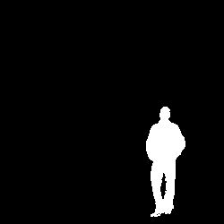

In [0]:
Image.fromarray(kornia.tensor_to_image((img['output'][0][0]*255).byte()))

In [0]:
#mmdmodels.UNet(n_channels=6, n_classes=2)

device = torch.device("cuda" if not hyperparams.hyperparameter_defaults['no_cuda'] else "cpu")
model_new  =mmdmodels.ResNetUNet(2)

model_new = mmdtraintest.load_model_for_infer(model_new, 
                                  '/content/drive/My Drive/EVA4/model_saves/model-26a8c7ae09.h5',
                                  device)

In [0]:
img['output'][0]

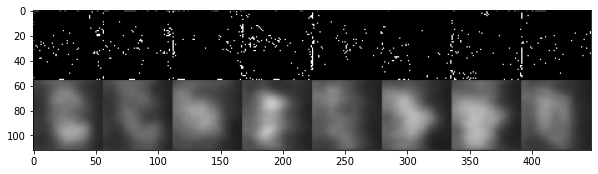

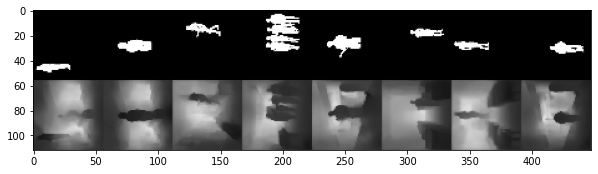

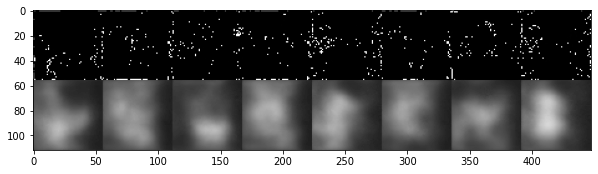

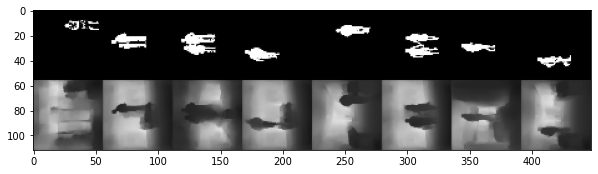

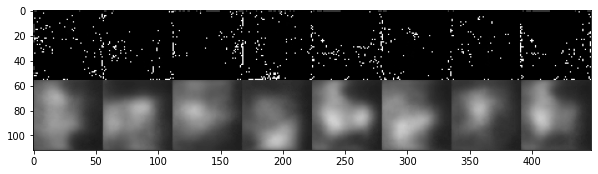

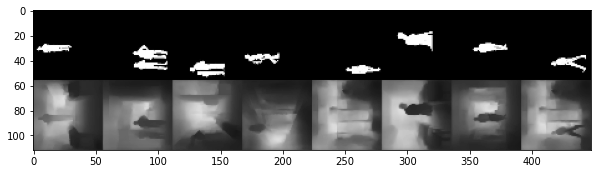

In [17]:
mmdtraintest.display_samples(model_new, test_loader, device)

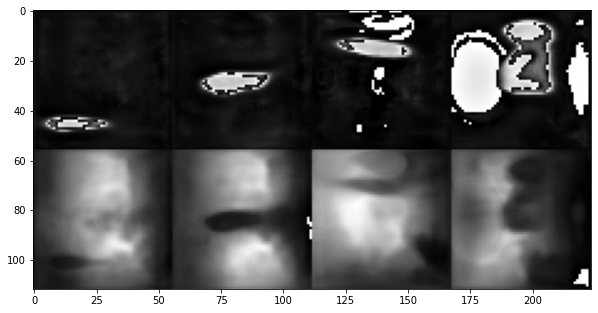

In [0]:
img = iter(test_loader).next()
dataset_len = 4#len(train_loader.dataset)

with torch.no_grad():
    output_val = model_new(img['input'].to(device)).to("cpu")
output_pred = torch.split(output_val,1,dim=1)
mask_pred = [kornia.tensor_to_image((output_pred[0][val].to("cpu")*255).byte()) for val in range(dataset_len) ]
depth_pred = [kornia.tensor_to_image((output_pred[1][val].to("cpu")*255).byte()) for val in range(dataset_len) ]

# mask_pred = [kornia.tensor_to_image(((output_pred[0][val].to("cpu")*0.0016620444341229432+0.057950844077600344)*255).byte()) for val in range(8) ]
# depth_pred = [kornia.tensor_to_image(((output_pred[1][val].to("cpu")*0.03551773442719045+0.3679109312239146)*255).byte()) for val in range(8) ]


img_shape = img['output'][0][1].shape[1]
mask_gt = [img['output'][0][val].reshape(img_shape,img_shape) for val in range(dataset_len) ]
depth_gt = [img['output'][1][val].reshape(img_shape,img_shape) for val in range(dataset_len) ]

#Image.fromarray(kornia.tensor_to_image((mask_pred*255).byte())),
plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_pred),np.hstack(depth_pred)]),cmap='gray')

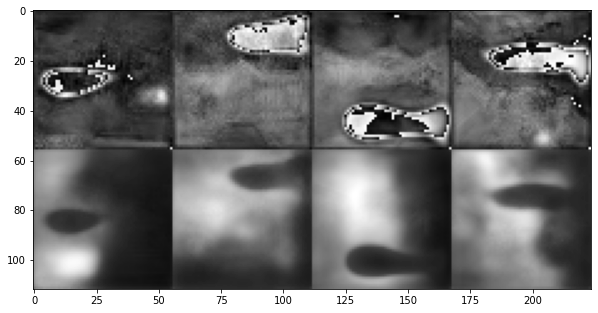

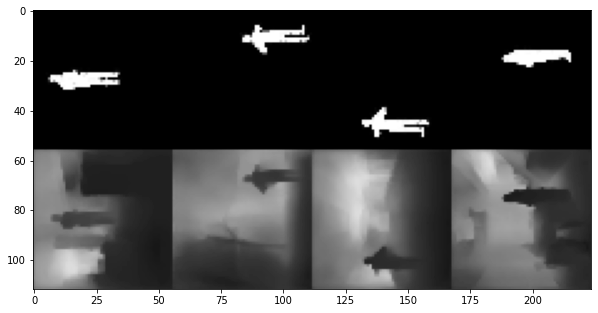

In [0]:
img = iter(train_loader).next()
dataset_len = 4#len(train_loader.dataset)
with torch.no_grad():
    output_val = model_new(img['input'].to(device)).to("cpu")
output_pred = torch.split(output_val,1,dim=1)
mask_pred = [kornia.tensor_to_image((output_pred[0][val].to("cpu")*255).byte()) for val in range(dataset_len) ]
depth_pred = [kornia.tensor_to_image((output_pred[1][val].to("cpu")*255).byte()) for val in range(dataset_len) ]

# mask_pred = [kornia.tensor_to_image(((output_pred[0][val].to("cpu")*0.0016620444341229432+0.057950844077600344)*255).byte()) for val in range(8) ]
# depth_pred = [kornia.tensor_to_image(((output_pred[1][val].to("cpu")*0.03551773442719045+0.3679109312239146)*255).byte()) for val in range(8) ]


img_shape = img['output'][0][1].shape[1]
mask_gt = [img['output'][0][val].reshape(img_shape,img_shape) for val in range(dataset_len) ]
depth_gt = [img['output'][1][val].reshape(img_shape,img_shape) for val in range(dataset_len) ]

#Image.fromarray(kornia.tensor_to_image((mask_pred*255).byte())),
plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_pred),np.hstack(depth_pred)]),cmap='gray')
plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_gt),np.hstack(depth_gt)]),cmap='gray')

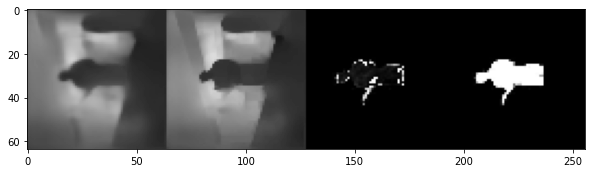

In [0]:
offset=4
plt.figure(figsize=(10,10)) 

plt.imshow(np.hstack([depth_pred[offset],
                      depth_gt[offset]*255,
                      mask_pred[offset]*mask_gt[offset].numpy(),
                      mask_gt[offset]*255]),cmap='gray')


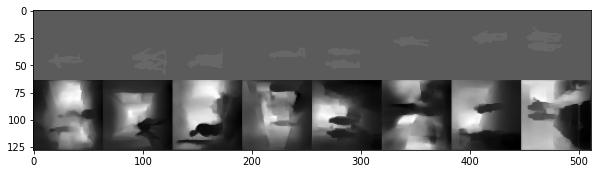

In [0]:
plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_gt),np.hstack(depth_gt)]),cmap='gray')

## Dice with RMSE

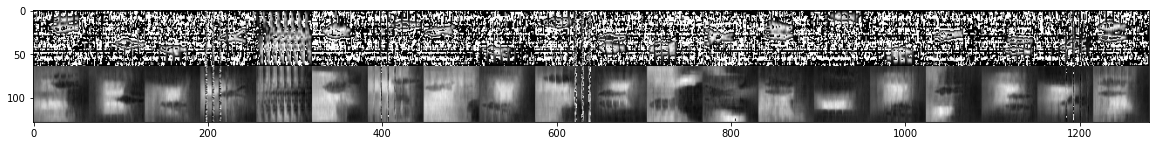

In [0]:
#Image.fromarray(kornia.tensor_to_image((mask_pred*255).byte())),
plt.figure(figsize=(20,20)) 
plt.imshow(np.vstack([np.hstack(mask_pred),np.hstack(depth_pred)]),cmap='gray')

In [0]:
offset = 5
plt.imshow(np.hstack([img['output'][1][offset].reshape(64,64),
                      depth_pred[offset]]),cmap='gray')

                    #   img['output'][0][offset].reshape(64,64),
                    #   mask_pred[offset]]),
                    #  cmap='gray')

In [0]:
plt.imshow(img['output'][0][offset].reshape(64,64),cmap='gray')

### BCE with SSIM Epoch = 10, Train = 20,000 Test=512

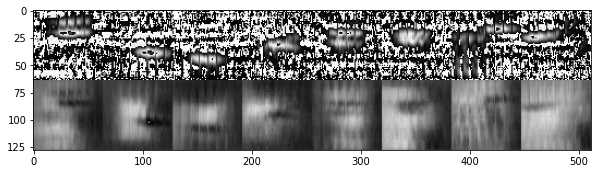

In [0]:
#Image.fromarray(kornia.tensor_to_image((mask_pred*255).byte())),
plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_pred),np.hstack(depth_pred)]),cmap='gray')

## Small batch RMSE

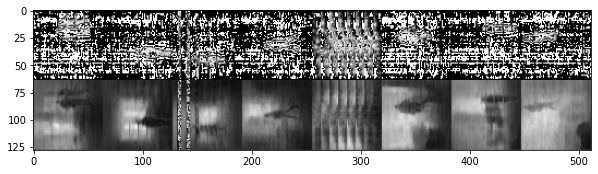

In [0]:
#Image.fromarray(kornia.tensor_to_image((mask_pred*255).byte())),
plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_pred),np.hstack(depth_pred)]),cmap='gray')

## BaseLine Predictions with plain RMSE

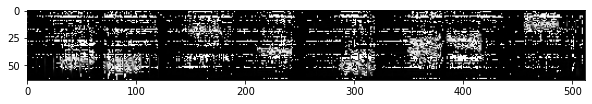

In [0]:
#Image.fromarray(kornia.tensor_to_image((mask_pred*255).byte())),
plt.figure(figsize=(10,10)) 
plt.imshow(np.hstack(mask_pred),cmap='gray')

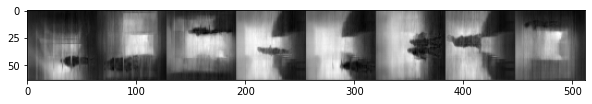

In [0]:
#Image.fromarray(kornia.tensor_to_image((mask_pred*255).byte())),
plt.figure(figsize=(10,10)) 
plt.imshow(np.hstack(depth_pred),cmap='gray')

In [0]:
!pip install kornia

     |████████████████████████████████| 163kB 6.0MB/s 


In [0]:
np.concatenate((img['input'][0][0].numpy(),img['input'][0][1].numpy()), axis=2).shape

(250, 250, 6)

In [0]:
 
pbar = tqdm(depth_dataset)

#bg_mean = np.zeros((4,3))
n, mean, M2 = (0.0,0.0,0.0)
for i_batch,img in enumerate(pbar):
    #img = depth_dataset[i_batch]
    #img_mean = np.mean(img, axis=(0,1))
    img_mean = np.array([ np.mean(iter_val/255.0,axis=(0,1)) for left_k,right_v in img.items() for iter_val in right_v ])
    n, mean, M2 = update_mean_variance((n, mean, M2), img_mean)

print(finalize_mean_variance(n, mean, M2))

In [0]:
# hf = h5py.File('data7.h5', 'w')
# #base_zip = ZipFile('/content/image_mask_gt2k6k.zip')
# #pbar = tqdm(depth_dataset)
# #hf.close()
# def hf_create_dataset(hdf_file, file_name, data):
#     hdf_file.create_dataset(
#                 name=file_name,
#                 data=data,
#                 compression="gzip", compression_opts=9
#                 )
# i_batch=0
# #for i_batch,img in enumerate(pbar):
# start = time.process_time()
# #try:
# for img in depth_dataset:
#     #key_name = 
#     if(i_batch > 100000):
#         break
#     #val_arr = [iter_val 
#     for left_k,right_v in img.items():
#         for inner_k, iter_val in right_v.items():
#             #print(inner_k)
#             hf_create_dataset(hf, inner_k ,iter_val)

#     if(i_batch % 1000 == 0 and i_batch > 1000):
#         current = time.process_time()
#         print("No:of records processed:{} Time Elapsed:{}".format(i_batch, current-start))
#     i_batch += 1

# end = time.process_time()
# print("No:of records processed:{} Time Elapsed:{}".format(i_batch, end-start))
# #except:

# #    hf.close()

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
from googleapiclient.discovery import build
gcs_service = build('storage', 'v1')

In [0]:
import uuid
bucket_name = 'colab-sample-bucket-' + str(uuid.uuid1())

body = {
  'name': bucket_name,
  # For a full list of locations, see:
  # https://cloud.google.com/storage/docs/bucket-locations
  'location': 'us',
}
gcs_service.buckets().insert(project=project_id, body=body).execute()
print('Done')

In [0]:
hf.close()

In [0]:
hf_read = h5py.File('data7.h5', 'r')

In [0]:
hf_read.keys()

<KeysViewHDF5 ['depth_image_023aa22186_classroom_1.jpg', 'depth_image_0ccf0b6adb_classroom_8.jpg', 'depth_image_0d06379c4e_classroom_12.jpg', 'depth_image_100078863e_classroom_10.jpg', 'depth_image_1000d68e48_classroom_2.jpg', 'depth_image_10023ed777_classroom_12.jpg', 'depth_image_10027aa3fa_classroom_4.jpg', 'depth_image_1002953763_classroom_1.jpg', 'depth_image_1002a448f4_classroom_10.jpg', 'depth_image_1002be3508_classroom_3.jpg', 'depth_image_1002e52563_classroom_14.jpg', 'depth_image_1002e75f62_classroom_15.jpg', 'depth_image_100317e99d_classroom_14.jpg', 'depth_image_1003212d72_classroom_8.jpg', 'depth_image_10033c4a69_classroom_8.jpg', 'depth_image_10038181d7_classroom_3.jpg', 'depth_image_1003ffcca2_classroom_10.jpg', 'depth_image_1004993b2d_classroom_13.jpg', 'depth_image_1004dd5dd3_classroom_16.jpg', 'depth_image_100659c8dd_classroom_17.jpg', 'depth_image_1006609a43_classroom_16.jpg', 'depth_image_10074a3520_classroom_8.jpg', 'depth_image_1007f75489_classroom_8.jpg', 'depth_

In [0]:
### Knuth/Welford algorithm to generate mean by addition of new samples to existing mean

def update_mean_variance(existingAggregate, newValue):
    (count, mean, M2) = existingAggregate
    count += 1
    delta = newValue - mean
    mean += delta / count
    delta2 = newValue - mean
    M2 += delta * delta2

    return (count, mean, M2)

# Retrieve the mean, variance and sample variance from an aggregate
def finalize_mean_variance(existingAggregate):
    (count, mean, M2) = existingAggregate
    if count < 2:
        return float('nan')
    else:
       (mean, variance, sampleVariance) = (mean, M2 / count, M2 / (count - 1))
       return (mean, variance, sampleVariance)

In [0]:
calc_mean,variance, _ = finalize_mean_variance((n, mean, M2))
print(calc_mean)
print(np.sqrt(variance))

[[0.56632738 0.51567622 0.45670792]
 [0.57469445 0.52241555 0.45992244]
 [0.05795104 0.05795104 0.05795104]
 [0.61635181 0.21432114 0.50569604]]
[[0.1076622  0.10650349 0.12808967]
 [0.11322354 0.11195428 0.13441683]
 [0.02640032 0.02640032 0.02640032]
 [0.09193359 0.07619106 0.04919082]]


In [0]:
#depth_map = np.hstack([depth_dataset[index_val]['output'][1] for index_val in myrandom_array])
depth_map = [depth_dataset[index_val]['output'][1] for index_val in myrandom_array]
mask_image = [depth_dataset[index_val]['output'][0] for index_val in myrandom_array]
bg_image = [depth_dataset[index_val]['input'][1] for index_val in myrandom_array]
fg_bg_image = [depth_dataset[index_val]['input'][0] for index_val in myrandom_array]
final_list = np.hstack([ mask_image, bg_image, fg_bg_image])

In [0]:
from matplotlib import pyplot as plt

In [0]:
plt.figure(figsize=(24,32))
plt.imshow(depth_map,cmap='gray')

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(100., 100.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 20),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, depth_map):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

In [0]:
plt.savefig('/content/drive/My Drive/EVA4/tsai/S15EVA4/depthmaptile.png')

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(100., 100.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 20),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, final_list):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

In [0]:
Image.fromarray(depth_dataset[0]['output'][0])

In [0]:
Image.fromarray(depth_dataset[0]['output'][1])

In [0]:
import glob
fileList = [file_name for file_name in glob.glob('/content/drive/My Drive/EVA4/tsai/S15EVA4/people_cropresize/*png')]
print("Number of images of people:{}".format(len(fileList)))

Number of images of people:110


In [0]:
import os

for file_name in fileList:
    image_name = os.path.basename(file_name)
    my_array = np.array(Image.open(file_name))
    print("FileName: {} Shape:{}".format(image_name, my_array.shape))

In [0]:
base_dir = '/content/drive/My Drive/EVA4/tsai/S15EVA4/people_cropresize/'
aug_path = '/content/drive/My Drive/EVA4/tsai/S15EVA4/people_cropresize/aug_images'
image_list = [ ]


for file_name in glob.glob(base_dir+"/*png")[:20]:
    basefile_name = os.path.basename(file_name)
    #print(basefile_name)
    mask_name = os.path.join(aug_path,"mask_"+basefile_name)
    flip_name = os.path.join(aug_path,"flip_"+basefile_name)
    flip_mask_name = os.path.join(aug_path,"mask_"+os.path.basename(flip_name))
    print(file_name,mask_name,flip_name,  flip_mask_name)
    image_list.append([np.array(Image.open(val)) for val in [file_name,mask_name,flip_name,  flip_mask_name ]])

In [0]:
for val in image_list:
    plt.imshow(np.hstack([val[0],val[2]]))
    plt.imshow(np.hstack([val[1],val[3]]))

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
#for iter in image_list:
for ax, im in zip(grid, image_list[2]):
    #print(ax., )
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap='gray')

In [0]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

In [0]:
model = ResNet50(weights='imagenet')

102973440/102967424 [==============================] - 1s 0us/step


In [0]:
model.summary()